In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import copy
import pandas as pd

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,1,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,3,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))


In [2]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/KAN_BaseConfig_SPRING.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]

Best_step = best_config[0].astype(int)
Best_lr = best_config[1]
Best_grid = best_config[2].astype(int)
Best_k = best_config[3].astype(int)
Best_internal_units = best_config[4].astype(int)
Best_batch = best_config[5].astype(int)
Best_lamb = best_config[6].astype(float)
Best_lamb_entropy = best_config[7].astype(float)

print("\nBest Configuration: Step: {}, Learning Rate: {}, Grid: {}, K: {}, Internal Units: {}, Batch Size: {}, Lamb: {}, Lamb Entropy: {}".format(Best_step, Best_lr, Best_grid, Best_k, Best_internal_units, Best_batch, Best_lamb, Best_lamb_entropy))


Best Configuration: Step: 100, Learning Rate: 0.01, Grid: 12, K: 3, Internal Units: 16, Batch Size: 64, Lamb: 0.01, Lamb Entropy: 10.0


In [3]:
model = KAN(width=[10, int(Best_internal_units), 1], grid=Best_grid, k=Best_k, auto_save=False, seed=0, device=device)
dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

for i in range(Best_internal_units):
    model.fix_symbolic(0, 9, i, 'sin', fit_params_bool=False)
    model.fix_symbolic(0, 8, i, 'sin', fit_params_bool=False)
        
model.auto_save = True
# model.fit(dataset, opt="LBFGS", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);

saving model version 0.1


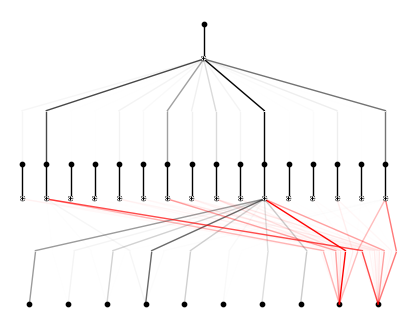

In [4]:
model.plot()

In [5]:
# 定义 k 折交叉验证
k = 3 # 例如，3折交叉验证
kf = KFold(n_splits=k, shuffle=True, random_state=42)

def evaluate_params(_model, threshold_1, threshold_2, Best_step, Best_batch, Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy):
    try:
        fold_losses = []
        for fold, (train_index, val_index) in enumerate(kf.split(train_input_tensor)):
            dataset = dict()
            # 获取训练和验证数据
            train_input_fold = train_input_tensor[train_index]
            train_label_fold = train_label_tensor[train_index]
            val_input_fold = train_input_tensor[val_index]
            val_label_fold = train_label_tensor[val_index]
            dataset['train_input'] = train_input_fold.clone().detach()
            dataset['train_label'] = train_label_fold.clone().detach()
            dataset['test_input'] = val_input_fold.clone().detach()
            dataset['test_label'] = val_label_fold.clone().detach()

            _model = _model.prune(threshold_1, threshold_2)
            try:
                _model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy)
                val_predictions = _model.forward(dataset['test_input'])
                val_loss = mean_squared_error(dataset['test_label'].detach().numpy(), val_predictions.detach().numpy())
            except Exception as e:
                print(f"Error during model fitting: {e}")
                val_loss = 100

            fold_losses.append(val_loss)

        # 计算当前超参数组合在所有折上的平均损失
        avg_val_loss = sum(fold_losses) / len(fold_losses)
        return {
            'threshold_1': threshold_1,
            'threshold_2': threshold_2,
            'avg_val_loss': avg_val_loss

        }
    except Exception as e:
        print(f"Error in evaluate_params: {e}")
        return {
            'threshold_1': threshold_1,
            'threshold_2': threshold_2,
            'avg_val_loss': 1000

        }

In [6]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/NN+KAN-SPIRNG.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]
Best_threshold_1 = best_config[0]
Best_threshold_2 = best_config[1]
print("\nBest Configuration: Best_threshold_1: {}, Best_threshold_2: {}".format(Best_threshold_1, Best_threshold_2))


Best Configuration: Best_threshold_1: 0.02, Best_threshold_2: 0.02


saving model version 0.1


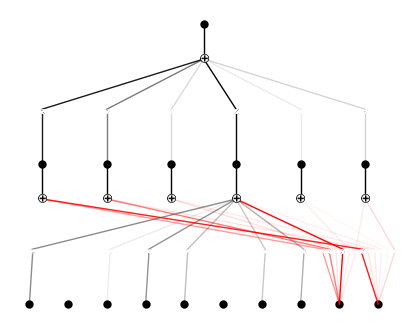

In [7]:
model = model.prune(node_th=Best_threshold_1, edge_th=Best_threshold_2);
model.auto_save = True
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.plot()

In [8]:
# source conde prune_input return input_mask
model,input_mask = model.prune_input()
# model.edge_scores
# model.node_scores

keep: [True, False, True, True, True, False, True, True, True, True]
saving model version 0.2


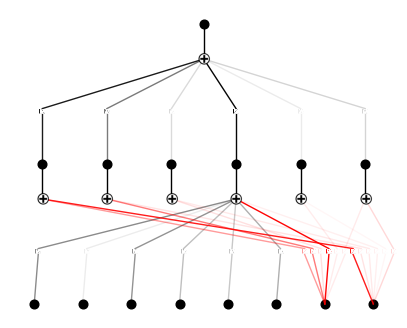

In [9]:
model.plot()

In [10]:
lib = ['x','x^2','exp','sqrt','tanh','sin','arctanh']
model.auto_symbolic(lib=lib)
# model.symbolic_formula()

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with x, r2=0.6242073774337769, c=1
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with x, r2=0.20360210537910461, c=1
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with x, r2=0.8953628540039062, c=1
fixing (0,2,4) with 0
fixing (0,2,5) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with x, r2=0.5155067443847656, c=1
fixing (0,3,4) with 0
fixing (0,3,5) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with 0
fixing (0,4,2) with 0
fixing (0,4,3) with x, r2=0.2760308086872101, c=1
fixing (0,4,4) with 0
fixing (0,4,5) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with x, r2=0.39706656336784363, c=1
fixing (0,5,4) with 0
fixing (0,5,5) with 0
skipping (0,6,0) since already symboli

In [11]:
# def revise_dataset(dataset,input_index):
#     dataset['train_input'] = dataset['train_input'][:,input_index]
#     dataset['test_input'] = dataset['test_input'][:,input_index]
#     return dataset
# true_indices = np.where(input_mask.detach().numpy())[0]
# dataset = revise_dataset(dataset,true_indices)
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr);

saving model version 0.4


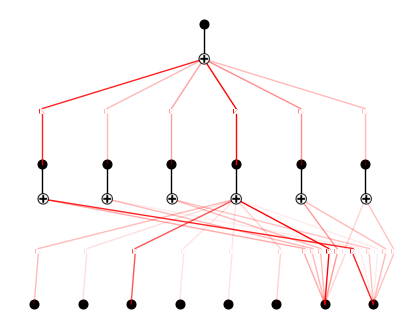

In [12]:
model.plot()

In [13]:
model.symbolic_formula()

([-0.147878405436938*x_1 + 0.0705247522572326*x_2 + 0.260715547621237*x_3 - 0.0595831004376474*x_4 - 0.0665124675244903*x_5 - 0.0961854641799234*x_6 - 0.199940860255781*sin(0.533616423606873*x_7 + 0.0406286790966988) - 0.0780071270595302*sin(0.713795185089111*x_7 - 0.146193221211433) + 0.120360933303804*sin(0.835395514965057*x_7 + 0.211806073784828) + 0.107377870258644*sin(1.29021561145782*x_7 + 0.318071395158768) + 0.961805992118203*sin(1.55316507816315*x_7 + 0.941126823425293) - 0.167863159751351*sin(1.58420360088348*x_7 + 0.322238087654114) + 0.140243869878714*sin(0.219426289200783*x_8 + 0.647644519805908) + 0.0422295616254414*sin(0.60089635848999*x_8 - 0.0163751244544983) - 0.114188251277058*sin(0.949861168861389*x_8 - 0.546780288219452) - 0.562417090685424*sin(1.06847858428955*x_8 - 0.472326159477234) - 0.126235427403802*sin(1.38979625701904*x_8 - 0.840504705905914) + 0.105112312769297*sin(1.8430061340332*x_8 + 0.181359648704529) - 0.397999839548226],
 [x_1, x_2, x_3, x_4, x_5, x_

In [14]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]

In [15]:
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))

pre_KAN_ = scaler_output.inverse_transform(pre_KAN)

result = dict()
result["KAN"] = evaluation(pre_KAN_,actual)

In [16]:
result

{'KAN': [420.13850999622133, 333.61013430139474, 0.04345812957990496]}

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import time

# SimpleCNN 模型
class SimpleCNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, conv_out_channels=16, time_step=24):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv1d(in_channels=num_inputs, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(conv_out_channels * time_step, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整输入形状为 (batch_size, num_inputs, time_step)
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

# SimpleLSTM 模型
class SimpleLSTM(nn.Module):
    def __init__(self, num_inputs, num_outputs, lstm_hidden_units=16):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=lstm_hidden_units, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, num_outputs)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

# CNNLSTM 模型
class CNNLSTM(nn.Module):
    def __init__(self, num_inputs, num_outputs, conv_out_channels=16, lstm_hidden_units=16, time_step=24):
        super(CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(in_channels=num_inputs, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=conv_out_channels, hidden_size=lstm_hidden_units, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整输入形状为 (batch_size, num_inputs, time_step)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # 调整回 LSTM 所需的输入形状 (batch_size, time_step, conv_out_channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

# SimpleTransformer 模型
class SimpleTransformer(nn.Module):
    def __init__(self, num_inputs, num_outputs, d_model=16, num_heads=2, num_layers=2):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(num_inputs, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_outputs)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x

# SimpleFCN1 模型
class SimpleFCN1(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units=16):
        super(SimpleFCN1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_outputs)
        )

    def forward(self, x):
        return self.net(x)

# SimpleFCN2 模型
class SimpleFCN2(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units1=32, hidden_units2=16):
        super(SimpleFCN2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units1),
            nn.ReLU(),
            nn.Linear(hidden_units1, hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, num_outputs)
        )

    def forward(self, x):
        return self.net(x)


def create_time_series_data(data, time_step):
    num_samples = data.shape[0]
    time_series_data = []
    for i in range(num_samples - time_step + 1):
        time_series_data.append(data[i:i + time_step].clone().detach().numpy())
    return torch.tensor(np.array(time_series_data))


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
results_df_cnn = pd.read_csv('./parameters_configuration/cnn_kan-SPRING.csv',index_col=0)
results_df_lstm = pd.read_csv('./parameters_configuration/lstm_kan-SPRING.csv',index_col=0)
results_df_cnn_lstm = pd.read_csv('./parameters_configuration/cnn_lstm_kan-SPRING.csv',index_col=0)
results_df_transformer = pd.read_csv('./parameters_configuration/transformer_kan-SPRING.csv',index_col=0)
results_df_fcn1 = pd.read_csv('./parameters_configuration/fcn1_kan-SPRING.csv',index_col=0)
results_df_fcn2 = pd.read_csv('./parameters_configuration/fcn2_kan-SPRING.csv',index_col=0)

In [19]:
# 找到每个模型的最佳配置
def get_best_config(results_df):
    best_config = results_df.loc[results_df['avg_val_loss'].idxmin(), ['learning_rate', 'batch_size', 'num_epochs', 'hidden_units', 'rho', 'mu']]
    return {
        'learning_rate': best_config['learning_rate'],
        'batch_size': int(best_config['batch_size']),
        'num_epochs': int(best_config['num_epochs']),
        'hidden_units': int(best_config['hidden_units']),
        'rho': best_config['rho'],
        'mu': best_config['mu']        
    }

# 获取每个模型的最佳配置
best_config_cnn = get_best_config(results_df_cnn)
best_config_lstm = get_best_config(results_df_lstm)
best_config_cnn_lstm = get_best_config(results_df_cnn_lstm)
best_config_transformer = get_best_config(results_df_transformer)
best_config_fcn1 = get_best_config(results_df_fcn1)
best_config_fcn2 = get_best_config(results_df_fcn2)

In [20]:
# 训练和评估模型的函数
def train_and_test_inter_model(model_class, learning_rate, batch_size, num_epochs, hidden_units, rho, mu, train_input_tensor, train_label_tensor, test_input_tensor, test_label_tensor, scaler_output, KAN_model, num_inputs=10, num_outputs=1, time_step=24):
    results = []
    lr = learning_rate
    batch_size = batch_size
    num_epochs = num_epochs
    hidden_units = hidden_units
    
    if model_class in [SimpleCNN, CNNLSTM]:
        _model = model_class(num_inputs, num_outputs, hidden_units, time_step)
    else:
        _model = model_class(num_inputs, num_outputs, hidden_units)

    # 分割数据
    train_input_fold = train_input_tensor
    train_label_fold = train_label_tensor
    val_input_fold = train_input_tensor
    val_label_fold = train_label_tensor

    # 如果模型是CNN或LSTM，转换数据为时间序列格式
    if issubclass(model_class, (SimpleCNN, SimpleLSTM, CNNLSTM)):
        train_input_fold_series = create_time_series_data(train_input_fold, time_step)
        train_label_fold_series = train_label_fold[time_step - 1:]  # 对齐标签
        val_input_fold_series = create_time_series_data(val_input_fold, time_step)
        val_label_fold_series = val_label_fold[time_step - 1:]  # 对齐标签
        
        train_input_fold = train_input_fold[time_step - 1:]
        train_label_fold = train_label_fold[time_step - 1:]
        val_input_fold = val_input_fold[time_step - 1:]
        val_label_fold = val_label_fold[time_step - 1:]

        # 创建数据加载器
        train_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(), train_input_fold_series.clone().detach(), train_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(), val_input_fold_series.clone().detach(), val_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=False
        )
    else:
        # 创建数据加载器
        train_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(),train_input_fold.clone().detach(), train_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(),val_input_fold.clone().detach(), val_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=False
        )
        
    # 如果模型是CNN或LSTM，转换数据为时间序列格式
    if issubclass(model_class, (SimpleCNN, SimpleLSTM, CNNLSTM)):
        test_input_series = create_time_series_data(test_input_tensor, time_step)
        test_label_series = test_label_tensor[time_step - 1:]  # 对齐标签
        
        test_input = test_input_tensor[time_step - 1:]
        test_label = test_label_tensor[time_step - 1:]
    else:
        test_input_series = test_input_tensor
        test_label_series = test_label_tensor
        
        test_input = test_input_tensor
        test_label = test_label_tensor

    # 确保第一个模型是 KAN_model
    model_ADD = KAN_ADD_NN(KAN_model, _model, rho, mu)
    optimizer_w1 = torch.optim.Adam([{'params': model_ADD.w1}, {'params': model_ADD.module1.parameters()}], lr=0.001)
    optimizer_w2 = torch.optim.Adam([{'params': model_ADD.w2}, {'params': model_ADD.module2.parameters()}], lr=0.001)

    output_inverse_all_kan = []
    output_inverse_all_ANN = []
    
    # 训练模型
    start_time = time.time()
    for epoch in range(num_epochs):
        model_ADD.train()
        for x, y, z in train_loader:
            model_ADD.admm_step(x, y, z, optimizer_w1, optimizer_w2, epoch)  # 使用可能不相同的输入 x 和 y
        # with torch.no_grad():        
        output_1 = model_ADD(test_input, test_input_series)
        output_inverse_ADD = scaler_output.inverse_transform(output_1.detach().numpy())
        output_2 = model_ADD.w1*model_ADD.module1(test_input)
        # + model_ADD.w2*model_ADD.module2(test_input_series)
        output_inverse_KAN = scaler_output.inverse_transform(output_2.detach().numpy())
        output_inverse_all_kan.append(output_inverse_KAN)
        output_inverse_all_ANN.append((output_inverse_ADD-output_inverse_KAN))
            
        # if (epoch + 1) % 10 == 0:
        #     loss = model_ADD.loss_func(x, y, z)
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


    # 验证模型
    model_ADD.eval()
    with torch.no_grad():
        output = model_ADD(test_input, test_input_series)
        output_inverse = scaler_output.inverse_transform(output.numpy())
        test_label_inverse = scaler_output.inverse_transform(test_label)

    return model_ADD, evaluation(output_inverse,test_label_inverse), output_inverse_all_kan, output_inverse_all_ANN, output_inverse

In [21]:
import torch
import torch.nn as nn

class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2, rho=10.0, mu=0.1):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1  # Neural network for f(x, theta1)
        self.module2 = module2  # Neural network for g(x, theta2)
        
        # Separate weights for w1 and w2
        self.w1 = nn.Parameter(torch.rand(1))
        self.w2 = nn.Parameter(torch.rand(1))
        
        self.rho = rho  # Penalty parameter for ADMM
        self.mu = mu    # Constraint parameter ||z|| < mu
        
        self.z = torch.zeros(1, requires_grad=False)  # Auxiliary variable z
        self.lambda_ = torch.zeros(1, requires_grad=False)  # Lagrange multiplier λ

    def forward(self, x1, x2):
        y1 = self.module1(x1)
        y2 = self.module2(x2)
        y = self.w1 * y1 + self.w2 * y2
        return y

    def loss_func(self, x1, x2, y_actual, update_w1=True):
        y_pred = self.forward(x1, x2)
        loss = torch.mean((y_pred - y_actual) ** 2)
        
        if not update_w1:
            # Add ADMM terms when updating w2
            loss = loss + self.lambda_ * (self.w2 - self.z) + (self.rho/2) * torch.norm(self.w2 - self.z)**2
            
        return loss

    def update_w1_theta1(self, x1, x2, y_actual, optimizer_w1):
        # Fix w2 and update w1, θ1
        self.w2.requires_grad_(False)
        self.module2.requires_grad_(False)
        
        optimizer_w1.zero_grad()
        loss = self.loss_func(x1, x2, y_actual, update_w1=True)
        loss.backward()
        optimizer_w1.step()
        
        self.w2.requires_grad_(True)
        self.module2.requires_grad_(True)

    def update_w2_theta2(self, x1, x2, y_actual, optimizer_w2):
        # Fix w1, θ1 and update w2, θ2
        self.w1.requires_grad_(False)
        self.module1.requires_grad_(False)
        
        optimizer_w2.zero_grad()
        loss = self.loss_func(x1, x2, y_actual, update_w1=False)
        loss.backward()
        optimizer_w2.step()
        
        self.w1.requires_grad_(True)
        self.module1.requires_grad_(True)

    def update_z(self):
        # Projection step: z = P_{||z||<μ}(w2 + λ/ρ)
        with torch.no_grad():
            proposed_z = self.w2.detach() + self.lambda_/self.rho
            norm = torch.norm(proposed_z)
            if norm >= self.mu:
                self.z = (proposed_z / norm) * self.mu
            else:
                self.z = proposed_z

    def update_lambda(self):
        # Update Lagrange multiplier: λ = λ + ρ(w2 - z)
        with torch.no_grad():
            self.lambda_ += self.rho * (self.w2.detach() - self.z)

    def admm_step(self, x1, x2, y_actual, optimizer_w1, optimizer_w2, epoch):   
        # # 每 10 轮将 mu 减半
        # if epoch % 10 == 0:
        #     self.mu *= 0.5
        # Step 1: Update w1 and θ1
        self.update_w1_theta1(x1, x2, y_actual, optimizer_w1)
        
        # Step 2: Update w2 and θ2
        self.update_w2_theta2(x1, x2, y_actual, optimizer_w2)
        
        # Step 3: Update z
        self.update_z()
        
        # Step 4: Update λ
        self.update_lambda()

In [22]:
model_ADD, fcn2_test_results, pre_fcn2_all_kan, pre_fcn2_all_ANN, pre_fcn2 = train_and_test_inter_model(SimpleFCN2, **best_config_fcn2, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model)

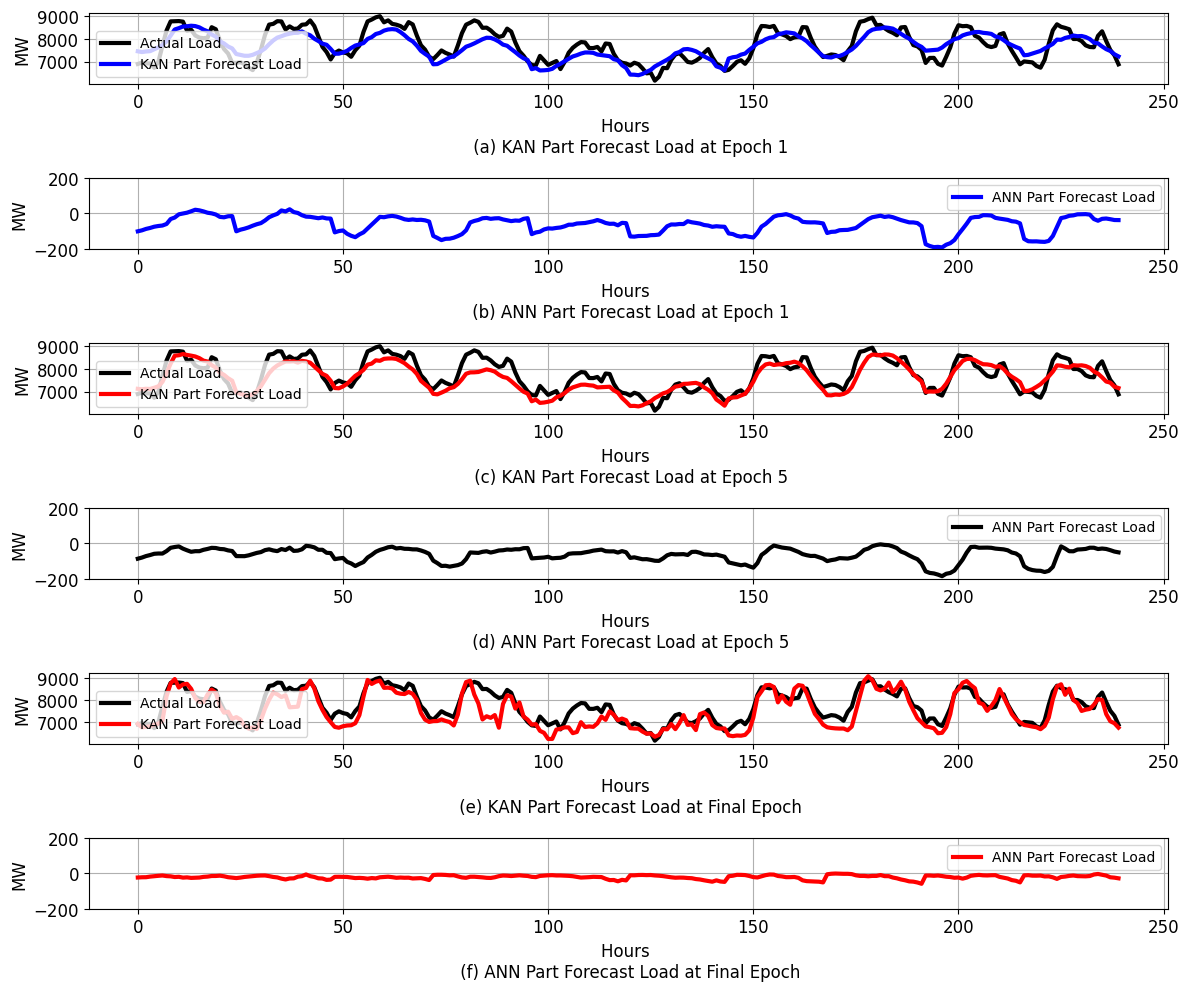

In [23]:
f = plt.figure(figsize=(12,10))

plt.subplot(6,1,1)
plt.plot(actual[:240],linewidth=3,c='black',label="Actual Load")
plt.plot(np.array(pre_fcn2_all_kan)[0,:240],linewidth=3,c='b',label="KAN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (a) KAN Part Forecast Load at Epoch 1",fontsize=12)
plt.ylabel("MW",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(6,1,2)
plt.plot(np.array(pre_fcn2_all_ANN)[0,:240],linewidth=3,c='b',label="ANN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (b) ANN Part Forecast Load at Epoch 1",fontsize=12)
plt.ylabel("MW",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-200,200)

plt.subplot(6,1,3)
plt.plot(actual[:240],linewidth=3,c='black',label="Actual Load")
plt.plot(np.array(pre_fcn2_all_kan)[5,:240],linewidth=3,c='r',label="KAN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (c) KAN Part Forecast Load at Epoch 5",fontsize=12)
plt.ylabel("MW",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(6,1,4)
plt.plot(np.array(pre_fcn2_all_ANN)[5,:240],linewidth=3,c='black',label="ANN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (d) ANN Part Forecast Load at Epoch 5",fontsize=12)
plt.ylabel("MW",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-200,200)

plt.subplot(6,1,5)
plt.plot(actual[:240],linewidth=3,c='black',label="Actual Load")
plt.plot(np.array(pre_fcn2_all_kan)[-1,:240],linewidth=3,c='r',label="KAN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (e) KAN Part Forecast Load at Final Epoch",fontsize=12)
plt.ylabel("MW",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(6,1,6)
plt.plot(np.array(pre_fcn2_all_ANN)[-1,:240],linewidth=3,c='r',label="ANN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (f) ANN Part Forecast Load at Final Epoch",fontsize=12)
plt.ylabel("MW",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-200,200)

plt.tight_layout()
plt.show()
f.savefig('./evolution_example.svg',format="svg",dpi=300)

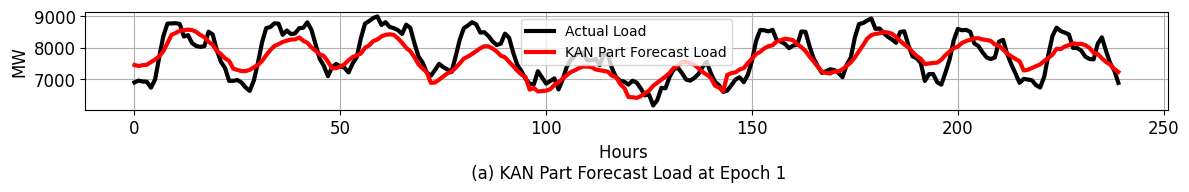

In [33]:
f1 = plt.figure(figsize=(12,2))
plt.plot(actual[:240], linewidth=3, c='black', label="Actual Load")
plt.plot(np.array(pre_fcn2_all_kan)[0,:240], linewidth=3, c='r', label="KAN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (a) KAN Part Forecast Load at Epoch 1", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
f1.savefig('./KAN_epoch1.svg', format="svg", dpi=300)

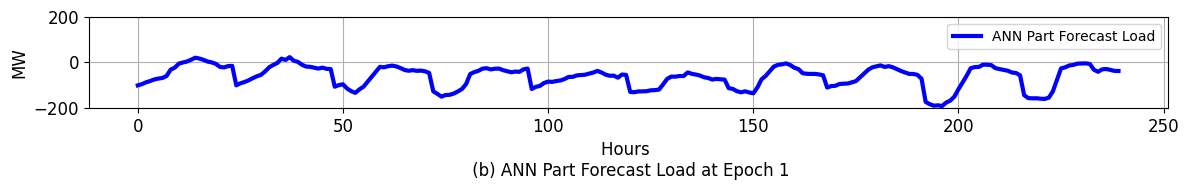

In [34]:
f2 = plt.figure(figsize=(12,2))
plt.plot(np.array(pre_fcn2_all_ANN)[0,:240], linewidth=3, c='b', label="ANN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (b) ANN Part Forecast Load at Epoch 1", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-200,200)
plt.tight_layout()
plt.show()
f2.savefig('./ANN_epoch1.svg', format="svg", dpi=300)

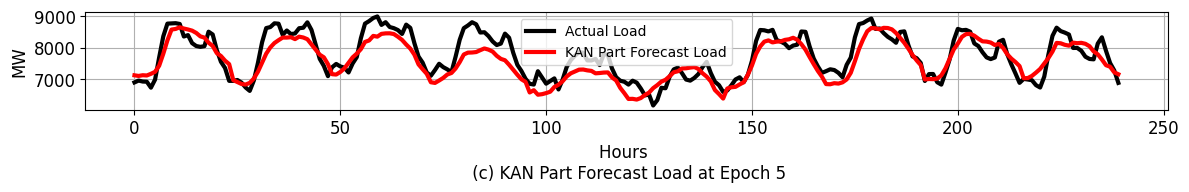

In [35]:
f3 = plt.figure(figsize=(12,2))
plt.plot(actual[:240], linewidth=3, c='black', label="Actual Load")
plt.plot(np.array(pre_fcn2_all_kan)[5,:240], linewidth=3, c='r', label="KAN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (c) KAN Part Forecast Load at Epoch 5", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
f3.savefig('./KAN_epoch5.svg', format="svg", dpi=300)

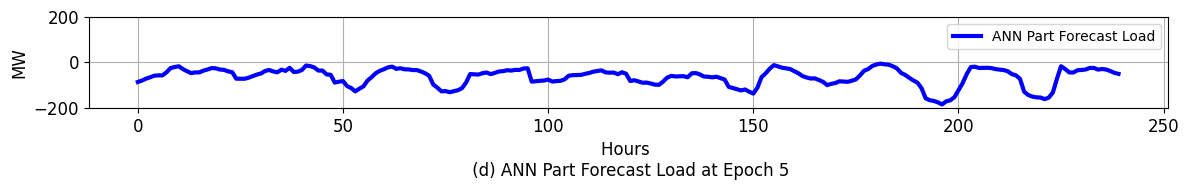

In [36]:
f4 = plt.figure(figsize=(12,2))
plt.plot(np.array(pre_fcn2_all_ANN)[5,:240], linewidth=3, c='b', label="ANN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (d) ANN Part Forecast Load at Epoch 5", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-200,200)
plt.tight_layout()
plt.show()
f4.savefig('./ANN_epoch5.svg', format="svg", dpi=300)

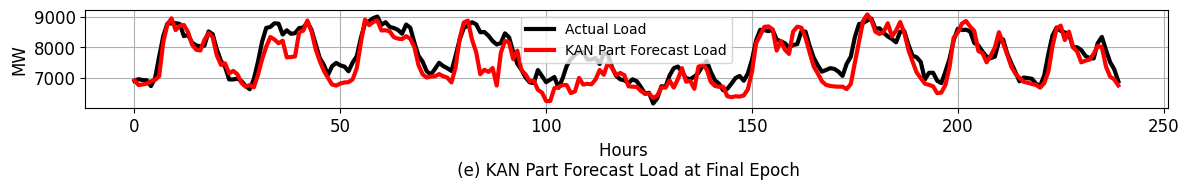

In [37]:
f5 = plt.figure(figsize=(12,2))
plt.plot(actual[:240], linewidth=3, c='black', label="Actual Load")
plt.plot(np.array(pre_fcn2_all_kan)[-1,:240], linewidth=3, c='r', label="KAN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (e) KAN Part Forecast Load at Final Epoch", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
f5.savefig('./KAN_final.svg', format="svg", dpi=300)

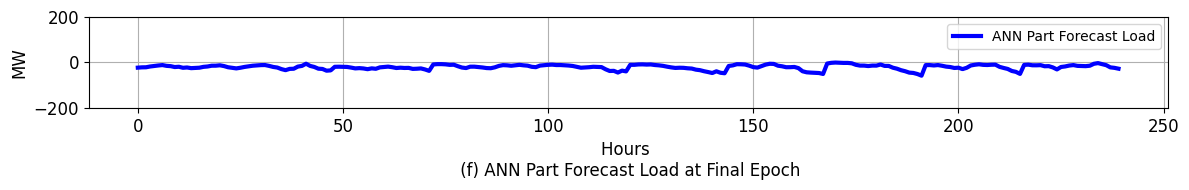

In [38]:
f6 = plt.figure(figsize=(12,2))
plt.plot(np.array(pre_fcn2_all_ANN)[-1,:240], linewidth=3, c='b', label="ANN Part Forecast Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours \n (f) ANN Part Forecast Load at Final Epoch", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-200,200)
plt.tight_layout()
plt.show()
f6.savefig('./ANN_final.svg', format="svg", dpi=300)